# Import

In [1]:
from glob2 import glob
import warnings
import torch
import numpy as np
import torch.nn as nn
import os
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

data_path = 'E:\\dl-learning\\pytorch\\pytorch-examples\\data\\'

# Dataset

In [2]:
pixel_mean = 33.32
pixel_std = 78.57
dataset = torchvision.datasets.MNIST(data_path, download=False)
print(len(dataset))

60000


In [3]:
class MnistDataset:
    
    def __init__(self, dataset, batch_size=5):
        self._data = dataset
        self.batch_size = batch_size
        self.num_samples = len(dataset)
        self._index = np.arange(self.num_samples)
        mod = self.num_samples % batch_size
        if mod > 0:
            self._index = np.hstack((self._index, np.random.choice(self._index, batch_size-mod)))
        self._idx_bat = [self._index[i:i+self.batch_size] for i in np.arange(0, self.num_samples, self.batch_size)]
        
    def shuffle_data(self):
        np.random.shuffle(self._index)
        self._idx_bat = [self._index[i:i+self.batch_size] for i in np.arange(0, self.num_samples, self.batch_size)]
    
    def __len__(self):
        return int(np.ceil(self.num_samples/self.batch_size))
    
    def __getitem__(self, idx):
        image = []
        label = []
        for i in self._idx_bat[idx]:
            x, y = self._data[i]
            x = (np.asarray(x).astype('float')-pixel_mean)/pixel_std  # 归一化 mean=0, std=1
            x = .5*x+.5
            image.append(torch.tensor(x.reshape(1,28,28), dtype=torch.float32))
            label.append(y)
        image = torch.stack(image)
        label = torch.tensor(label)
        return image, label
        

In [4]:
# mnistdata = MnistDataset(dataset, batch_size=5)

In [5]:
# t=torch.zeros(5,10)
# cls=mnistdata[0][1]

In [6]:
# t[range(5),cls]=1.0

# Model

In [7]:
class ModelG(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelG, self).__init__()
        self.fc2 = nn.Linear(10, 1000)
        self.fc = nn.Linear(self.z_dim+1000, 64*28*28)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 5, 1, 2)
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self, x, labels):
        """
        x: (batch_size, z_dim)
        labels: (batch_size, 10)
        """
        batch_size = x.size(0)
        y_ = self.fc2(labels)  # (b, 10)->(b,1000)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)  # (b,1000)+(b,z_dim)->(b, 1000+z_dim)
        x = self.fc(x)  # (b, 1000+z_dim)->(b, 64*28*28)
        x = x.view(batch_size, 64, 28, 28)  # (b, 64*28*28)->(b, 64, 28, 28)
        x = self.bn1(x) 
        x = F.relu(x)
        x = self.deconv1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv2(x)
        self.bn3(x)
        x = F.relu(x)
        x = torch.tanh(x)
        return x
    
    
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1  = nn.Linear(64*28*28+1000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.fc3 = nn.Linear(10, 1000)

    def forward(self, x, labels):
        """
        x: (b, 1, 28, 28)
        labels: (b, 10)
        """
        batch_size = x.size(0)
        x = self.conv1(x)  # (b, 1, 28, 28)->(b, 32, 28, 28)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)  # (b, 32, 28, 28)->(b, 64, 28, 28)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(batch_size, 64*28*28)  # (b, 64, 28, 28)->(b, 64*28*28)
        y_ = self.fc3(labels)  # (b, 10)->(b, 1000)
        y_ = F.relu(y_)
        x = torch.cat([x, y_], 1)  # (b, 1000)+(b, 64*28*28)->(64*28*28+1000, 1024)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # (b,1024)->(b,1)
        return torch.sigmoid(x)

In [8]:
# z_dim=8
# z = torch.randn(1,8)
# label = torch.zeros(1,10)
# label[0]=1

In [9]:
# G = ModelG(z_dim)

In [10]:
# g_out = G(z, label)

In [11]:
# g_out.shape

In [12]:
# D=ModelD()

In [13]:
# d_out = D(g_out, label)

In [14]:
# d_out.shape

# Training

In [15]:
start_epoch = 1
epochs = 1
# lr = .0005
lr_d = .001
lr_g = .001
batch_size = 64
latent_dim = 32


def calc_acc(pred, true, th=.5):
    with torch.no_grad():
        pred = pred>th
        true = true.byte()
        return (pred==true).float().mean()
    

def to_onehot(label, cls=10):
    onehot = torch.zeros(label.shape[0], cls)
    onehot[range(label.shape[0]), label]=1.0
    return onehot

def to_onehot_fake(label, cls=10):
    fake_label = [np.random.choice(list(set(range(cls))-set([i]))) for i in label]
    onehot = torch.zeros(label.shape[0], cls)
    onehot[range(label.shape[0]), fake_label]=1.0
    return onehot

def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

In [16]:
mnistdata = MnistDataset(dataset, batch_size=batch_size)
num_iters = len(mnistdata)
print(num_iters)

938


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()

netG = ModelG(latent_dim).to(device)
netD = ModelD().to(device)
# netG.apply(inplace_relu)
# netD.apply(inplace_relu)

real_label = 1
fake_label = 0

In [18]:
optimizer_G = optim.SGD(netG.parameters(),lr=lr_g)
optimizer_D = optim.SGD(netD.parameters(),lr=lr_d)
bce_loss = nn.BCELoss()

In [19]:
fixed_vector = torch.randn(5,latent_dim).to(device)

In [20]:
y_true = torch.zeros(batch_size).to(device)

for i in range(start_epoch, start_epoch+epochs):
    mnistdata.shuffle_data()
    for j in range(num_iters):
        
        optimizer_D.zero_grad()
        
        image = mnistdata[j][0].to(device)
        label = to_onehot(mnistdata[j][1]).to(device)
        y_pred = netD(image, label)
        y_true.fill_(real_label)
        loss_D = bce_loss(y_pred.view(-1), y_true)
        loss_d_real = loss_D.item()
        acc_d_real = calc_acc(y_pred.view(-1), y_true)
        loss_D.backward()
        
        label = to_onehot_fake(mnistdata[j][1]).to(device)
        y_pred = netD(image, label)
        y_true.fill_(fake_label)
        loss_D = bce_loss(y_pred.view(-1), y_true)
        loss_d_fake2 = loss_D.item()
        acc_d_fake2 = calc_acc(y_pred.view(-1), y_true)
        loss_D.backward()
        
        latent_vector = torch.randn(batch_size,latent_dim).to(device)
        label = to_onehot(np.random.randint(0,10,(batch_size,))).to(device)
        image = netG(latent_vector, label)
        y_pred = netD(image.detach(), label)  # 非常关键 detach ！！！
#         y_true.fill_(fake_label)
        loss_D = bce_loss(y_pred.view(-1), y_true)
        loss_d_fake = loss_D.item()
        acc_d_fake = calc_acc(y_pred.view(-1), y_true)
        loss_D.backward()
        
        optimizer_D.step()
        
#         torch.cuda.empty_cache()
        
        optimizer_G.zero_grad()

        y_pred = netD(image, label)
        y_true.fill_(real_label)
        loss_G = bce_loss(y_pred.view(-1), y_true)
        acc_g = calc_acc(y_pred.view(-1), y_true)
        loss_g = loss_G.item()
        
        loss_G.backward()
        
        optimizer_G.step()
        
#         torch.cuda.empty_cache()
        
        print("[{}/{}][{}/{}]  loss_D: ({:.3f},{:.3f},{:.3f})  loss_G: {:.3f}  acc_D: ({:.3f},{:.3f}{:.3f})  acc_G: {:.3f}"\
              .format(i, start_epoch+epochs-1, j+1, num_iters, loss_d_real, loss_d_fake2, loss_d_fake, loss_g, acc_d_real, 
                      acc_d_fake2, acc_d_fake, acc_g), end='\r')
        
#     gen_img = netG(fixed_vector).detach().cpu().numpy().reshape(5,28,28)
#     mer_img = np.hstack([i for i in gen_img])
#     im = PIL.Image.fromarray((mer_img*255).astype('uint8'))
#     im.save('mnist_gan/{:0>3d}.png'.format(i))

# Testing

In [25]:
img=image.detach().cpu().numpy().reshape(batch_size,28,28)
lab=label.detach().cpu().numpy().reshape(batch_size,10).argmax(axis=1)

Text(0.5, 1.0, '3')

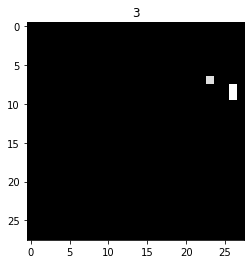

In [40]:
ind = np.random.randint(0,batch_size)
plt.imshow(img[ind], cmap='gray')
plt.title(str(lab[ind]))

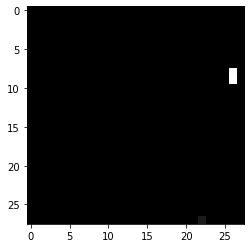

In [23]:
x = torch.randn(1, latent_dim).to(device)
l = torch.zeros(1, 10).to(device)
l[0,np.random.randint(0,10)]=1
img = netG(x,l).detach().cpu().numpy()

plt.imshow(img[0][0], cmap='gray')